# **Initialize Google Earth Engine API and Folium**

To first start using the Google Earth Engine API, you need to install and then authorize your account

In [ ]:
!pip install earthengine-api # GEE API
!pip install folium # Folium, which is a library that will help display our imagery

In [ ]:
#Import Google Earth Engine (GEE), authenticate, and initialize
import ee
ee.Authenticate()
ee.Initialize(project="ee-nathy")

Now that we have Google Earth Engine initalized, let's download Sentinel-2 Optical Imagery for the city of Munich

# **GEE: Load Sentinel-2 Data**

Let's first start by loading the city boundary that is specific to Munich

In [ ]:
"""City information can be found here: https://code.earthengine.google.com/?scriptPath=users%2Fsat-io%2Fawesome-gee-catalog-examples%3Apopulation-socioeconomics%2FGEOBOUNDARIES
Select "Run"
on the left hand side there will be dropdown boxes, use these to select your country/region/city
Use the inspector tool to click within the polygon and on the right hand side, continue to click the drop downs until you get to the objects properties,
from there, look in teh list to find "shapeID"
"""


# Load city boundaries and select Munich
ShapeID = ['DEU-ADM2-3_0_0-B89'] # Munich specific boundary
borders = ee.FeatureCollection('projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM2') # FeatureCollection of HPSCGS-ADM3 boundaries
boundary = borders.filter(ee.Filter.inList('shapeID', ShapeID)).geometry() # Filter the FeatureCollection for the Munich boundary

Select a date to download

In [ ]:
#Select start and end date for imagery
startDate = "2023-05-01";
endDate = "2023-06-30";

**Spectral Bands**

Sentinel-2 detectors captures imagery in 12 different spectral bands, each sensitive to different wavelengths of light. By combining these bands in various ways, we can perceive distinct aspects of the Earth's surface. For example, combining the red, green, and blue bands provides a natural color image, akin to what our eyes see. Utilizing the near-infrared and red bands reveals vegetation health, as healthy plants reflect more near-infrared light. Combining shortwave-infrared bands helps in distinguishing between different surface materials and water bodies, as they respond differently to these wavelengths. Overall, these band combinations allow us to detect changes in land cover, monitor vegetation health, identify water bodies, and assess various environmental and agricultural factors, enhancing our understanding of Earth's dynamics. (See False Composites section below for more)


***Sentinel-2 Bands***

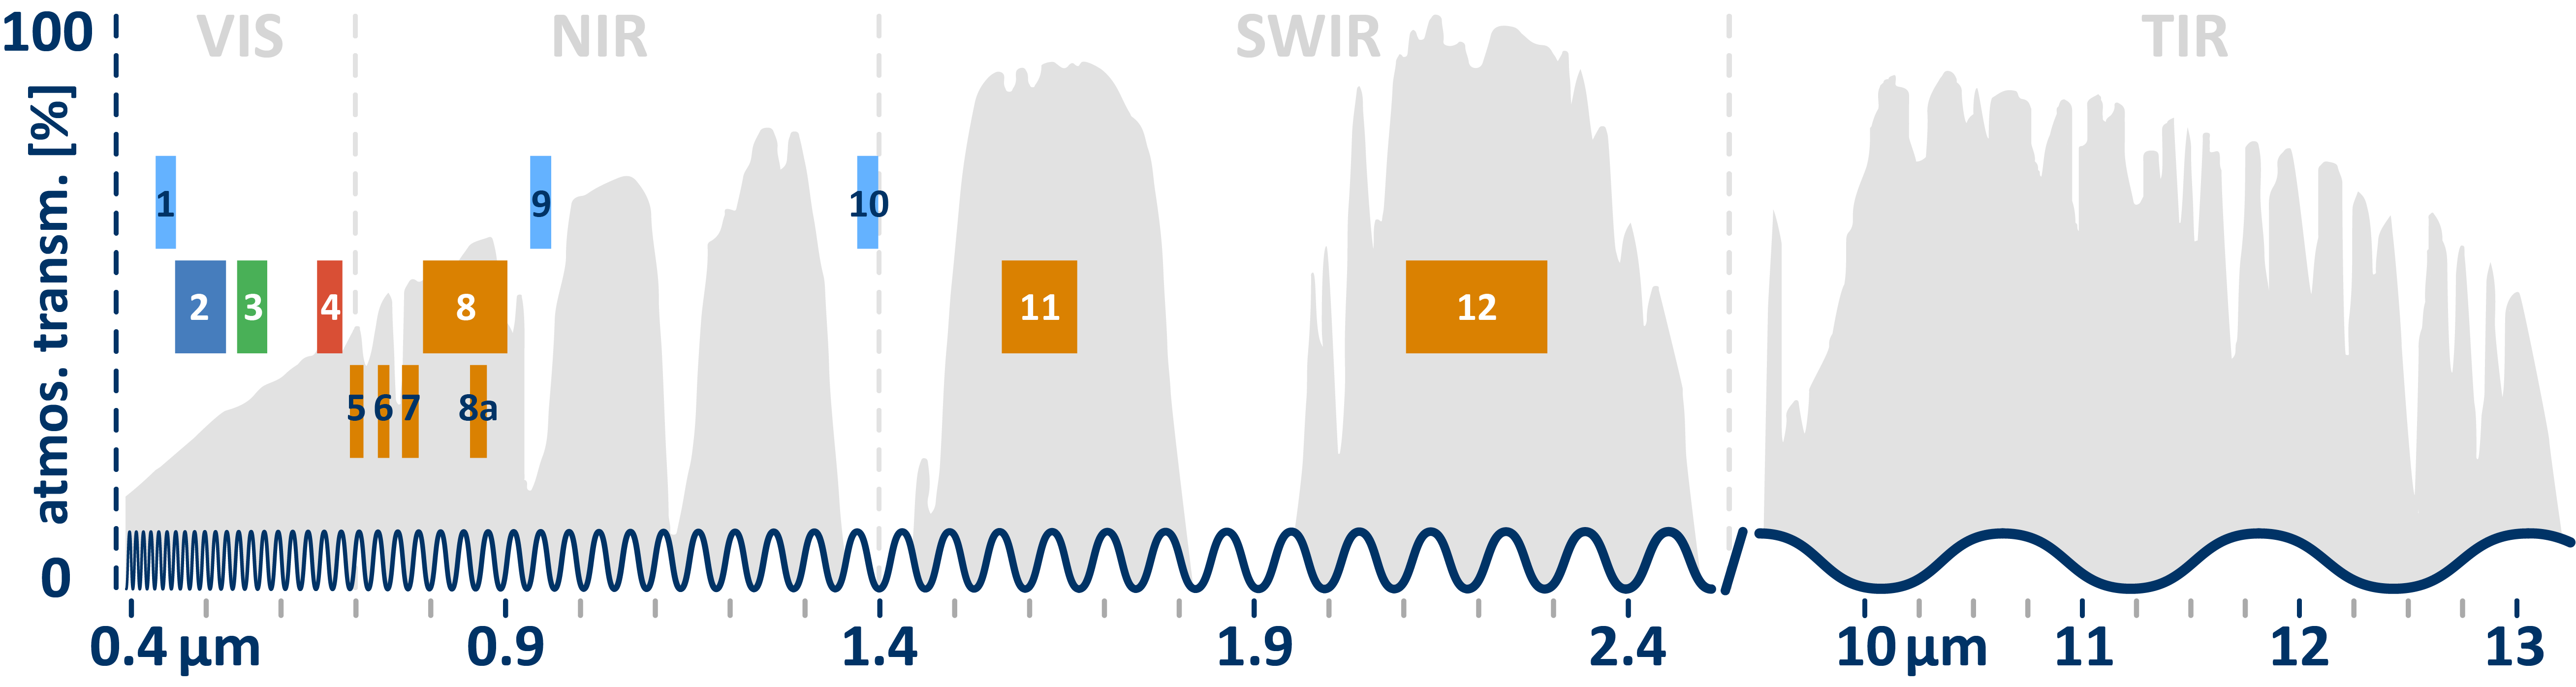

Let's select all of the bands to download for now

In [ ]:
#Select  bands from Sentinel-2 image
bands = ['B1', 'B2', 'B3', 'B4','B5', 'B6', 'B7', 'B8', 'B8A','B9',"B11", 'B12', "MSK_CLDPRB"]

Let's add all of our selects and download Sentinel-2 imagery for Munich during May and June 2023

In [ ]:
# Select Sentinel-2 Image COllection and filter Image Collection by date and select bands
S2A_ImageCollection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(startDate, endDate).filter(ee.Filter.bounds(boundary))
print("print all metadata:", S2A_ImageCollection.getInfo())

print all metadata: {'type': 'ImageCollection', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B6', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B7', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B8', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B8A', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B9', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {

How many images are available?

In [ ]:
print('Amount of available Images in the ImageCollection of Munich in June 2023:', S2A_ImageCollection.size().getInfo())

Amount of available Images in the ImageCollection of Munich in June 2023: 48


Sometimes, having so many images is helpful as we can them mosaic them.

**Mosaicing Together Images**

GEE's mosaic() function allows us to mosaick together multiple Sentinel-2 satellite images. IE, it allows us to combine various acquisitions into a single, continuous composite image. This capability is valuable for several reasons.

First, it helps reduce the impact of cloud cover in individual images, providing a clearer and more complete view of the Earth's surface. We did not originally filter for clouds, so in the next few steps, the image you will see will be cloudy. Clouds are a major obstacle for optical imagery and obscure our ability to "see" earth's surface. We will filter clouds in the next section.


Second, mosaicking enables the creation of composite images over time, making it ideal for monitoring seasonal changes in vegetation or urban development.

Third, mosaicking allows for the creation of large, continuous images covering extensive areas, simplifying the analysis and visualization of large-scale environmental phenomena

In [ ]:
#Mosaic the Image Collection to make it a singular Image
S2A_BaseImage_Mosaic = S2A_ImageCollection.mosaic()
print("print all metadata:",S2A_BaseImage_Mosaic.getInfo())

# Clip the base image by the Munich boundaries to ensure we only get an image that is the size of Munich
Munich2023_Clipped = S2A_BaseImage_Mosaic.clip(boundary)

print all metadata: {'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B6', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B7', 'data_type': {'type': 'PixelType'

We can now visualize our image of Munich

In [ ]:
#Import the Folium Library
import folium

#Define a method for displaying EE image tiles to a folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles = map_id_dict['tile_fetcher'].url_format,
      attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name = name,
      overlay = True,
      control = True
  ).add_to(self)


# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
visParams = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 4000
}

# Create a folium map object
my_map = folium.Map(location = [48.1351, 11.5820], zoom_start=12)

#Display

my_map.add_ee_layer(Munich2023_Clipped, visParams, "Munich2023")

# Add a layer control panel to the map
my_map.add_child(folium.LayerControl())

#Display the Map
#display(my_map)


#**GEE: Filtering Clouds**

As you can see in the above image, clouds are significantly disrupting our ability to visualize what is occuring on earth's surface. Below, are different examples of how to filter images

In [ ]:
#Check Image Collection for least cloudy image. **This code within this code box is NOT how you should filter images for clouds. This is just so you can understand how many images are severly obstructed by clouds. This is JUST filtering for scences that contain less than 30% clouds

collectionList = S2A_ImageCollection.toList(S2A_ImageCollection.size())
collectionSize = collectionList.size().getInfo()
for i in range(collectionSize):
  cloud_percentage = ee.Image(collectionList.get(i)).get('CLOUDY_PIXEL_PERCENTAGE').getInfo()
  #If Then Statement for cloud coverage that is > 30% cloudy
  cloudiness = ee.Image(collectionList.get(i)).get('CLOUDY_PIXEL_PERCENTAGE').getInfo()
  CloudImageID = ee.Image(collectionList.get(i)).id().getInfo()
  if cloudiness >= 30.0:
       print('CLOUDY_PIXEL_PERCENTAGE:', cloud_percentage, "// Too cloudy to use?", "Yes")
  else:
       print('CLOUDY_PIXEL_PERCENTAGE:', cloud_percentage, "// Too cloudy to use?", "No", "// Cloud Image ID:",  CloudImageID )




CLOUDY_PIXEL_PERCENTAGE: 100 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 100 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 68.044376 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 79.36461 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 82.576025 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 75.11372 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 99.998605 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 99.895579 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 100 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 99.999851 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 99.990821 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 93.657339 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 99.88299 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 99.723905 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 86.886209 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 84.468573 // Too cloudy to use? Yes
CLOUDY_PIXEL_PERCENTAGE: 89.801514 // Too clo

## **Filter Clouds**

Let's update our above S2A_ImageCollection with a cloud filter

In [ ]:
# Before using a mosaic to create the image, filter out cloudy images that have a cloud pixel percentage higher than 30. Typically, 10% to 20% is better
S2A_Image_Filtered_Clouds_30 = S2A_ImageCollection.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) # select the first() image to display an image
Munich2023_Clipped_Cloud_30 = S2A_Image_Filtered_Clouds_30.first().clip(boundary)


In [ ]:
# Display it on the Map
my_map.add_ee_layer(Munich2023_Clipped_Cloud_30, visParams, "Munich2023_Clipped_Cloud_30")
display(my_map)

In the above image, while we have significantly minimized the amount of clouds, there are still some visible, even though we have mosaicked all of the cloud filtered images into one image (ie: in all of the images, there were some clouds in that are). Let's mask these from the image.

## **Mask Clouds**

In [ ]:
# Use this function to mask cloud pixels
def maskClouds(image):
    qa = image.select('MSK_CLDPRB')
    # Create a binary mask using the cloud probability band
    binary_mask = qa.lt(50)
    # Return the binary mask image
    return image.updateMask(binary_mask)

In [ ]:
S2A_Image_Filtered_Clouds_30_Masked= S2A_Image_Filtered_Clouds_30.map(maskClouds)

While we added a mask to all of the images within our ImageCollection by a boundary, we cannot clip an ImageCollection. Let's use the first() function to select the first image within our ImageCollection.

In [ ]:
# Display it on the Map
my_map = folium.Map(location = [48.1351, 11.5820], zoom_start=12)
my_map.add_ee_layer(S2A_Image_Filtered_Clouds_30_Masked.first().clip(boundary) , visParams, "Munich2023_Clipped_Cloud_30_Masked")
my_map.add_child(folium.LayerControl())
display(my_map)

Notice all of the missing aspects of this image. By masking the clouds, we are essentially removing them from the image. This can be resolved by using every image within our ImageCollection, and taking the median of each pixel then combining it into one image.

***Using the Median***

The median() function calculates the pixel-wise median value from a collection of images or a multi-band image stack. It essentially computes the median for each pixel across the input images, providing a composite image where each pixel's value represents the median value of that pixel's location in the stack of images.

Since we masked the clouds in the above step, we need to "fill in" these black spaces. This can be done using the median()

In [ ]:
# Display it on the Map
my_map = folium.Map(location = [48.1351, 11.5820], zoom_start=12)
my_map.add_ee_layer(S2A_Image_Filtered_Clouds_30_Masked.median().clip(boundary) , visParams, "Munich2023_Clipped_Cloud_30_Masked")
my_map.add_child(folium.LayerControl())
display(my_map)



# **GEE: Metadata Query**

**Metadata**

Metadata is essential information associated with images and their acquisition. It includes details such as the date and time of image capture, sensor characteristics, spatial resolution, cloud cover percentage, geographic coordinates, and other technical specifications.

Querying metadata is valuable for multiple reasons. First, it helps us select the most suitable imagery for their specific needs, considering factors like temporal relevance and cloud cover to ensure data quality. Second, it supports the organization and retrieval of large satellite image datasets by enabling efficient search and filtering. Moreover, metadata allows for the tracking of changes and trends over time, aiding in environmental monitoring, land-use planning, and disaster management.

Let's look at all of the available metadata

In [ ]:
Metadata =  ee.ImageCollection("COPERNICUS/S2_SR").filterDate(startDate, endDate).filter(ee.Filter.bounds(boundary)).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).sort('CLOUDY_PIXEL_PERCENTAGE').first()

#Call all available metadata
print("print all metadata:", Metadata.getInfo())

print all metadata: {'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [1830, 1830], 'crs': 'EPSG:32632', 'crs_transform': [60, 0, 600000, 0, -60, 5400000]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32632', 'crs_transform': [10, 0, 600000, 0, -10, 5400000]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32632', 'crs_transform': [10, 0, 600000, 0, -10, 5400000]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32632', 'crs_transform': [10, 0, 600000, 0, -10, 5400000]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [5490, 5490], 'crs': 'EPSG:32632', 'crs_transform': [20, 0, 600

In the printout above, you can see the band information. An easier way to see the band information is provided below:

In [ ]:
# Available Bands

# Get band names and information
bandNames = Metadata.bandNames().getInfo()

# Print the band names and information
print('Band Info:', bandNames)


Band Info: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']


Below you can learn more about each band:

In [ ]:
# Band Type

# Get band types
bandTypes = Metadata.bandTypes().getInfo()

# Print the types
print('Band Types:', bandTypes)

Band Types: {'AOT': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'B1': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'B11': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'B12': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'B2': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'B3': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'B4': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'B5': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'B6': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'B7': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'B8': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'B8A': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'B9': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'MSK_CLDPRB': {'type': 'PixelType'

Let's look specifically at Band 2

In [ ]:
#Select a Band
B2 = Metadata.select("B2").getInfo()
print("B2:", B2)

B2: {'type': 'Image', 'bands': [{'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32632', 'crs_transform': [10, 0, 600000, 0, -10, 5400000]}], 'id': 'COPERNICUS/S2_SR/20230625T101601_20230625T101601_T32UPU', 'version': 1687800506411760.0, 'properties': {'SPACECRAFT_NAME': 'Sentinel-2A', 'SATURATED_DEFECTIVE_PIXEL_PERCENTAGE': 0, 'BOA_ADD_OFFSET_B12': -1000, 'CLOUD_SHADOW_PERCENTAGE': 0.000338, 'system:footprint': {'type': 'LinearRing', 'coordinates': [[10.360144228609053, 48.744996979113004], [10.360142781468607, 48.744985727239424], [10.346997731366994, 48.25131107397423], [10.334202087948276, 47.75759116485154], [10.33425545973951, 47.75754906378209], [10.334300522746355, 47.75750285047891], [10.334322433740617, 47.75749979749882], [11.797833092095516, 47.731140783279784], [11.797896686851736, 47.731175798636215], [11.797966226015848, 47.73120524041956], [11.797971179197713, 47.73121989715763], [11.

#### Projection

The projection in which your imagery is in, is always essential to know, as every image/feature you work with needs to be in the same projection.

In [ ]:
# Projection of Band 2
B2projection = Metadata.select('B2').projection()
print(B2projection.getInfo())

{'type': 'Projection', 'crs': 'EPSG:32632', 'transform': [10, 0, 600000, 0, -10, 5400000]}


#### Scale / Spatial Resolution

in meters

Chapter 1: Introduction to Remote Sensing Systems, Data, and Applications discusses the different types of Resolution. The Sentinel-2 constellation includes 2 satellites, A & B. Each have a temporal resolution of 10 days, when combined, create a temporal resolution of 5 days. It has a radiometric resolution of 12-bits, and the spectral resolution can be seen in the below table.


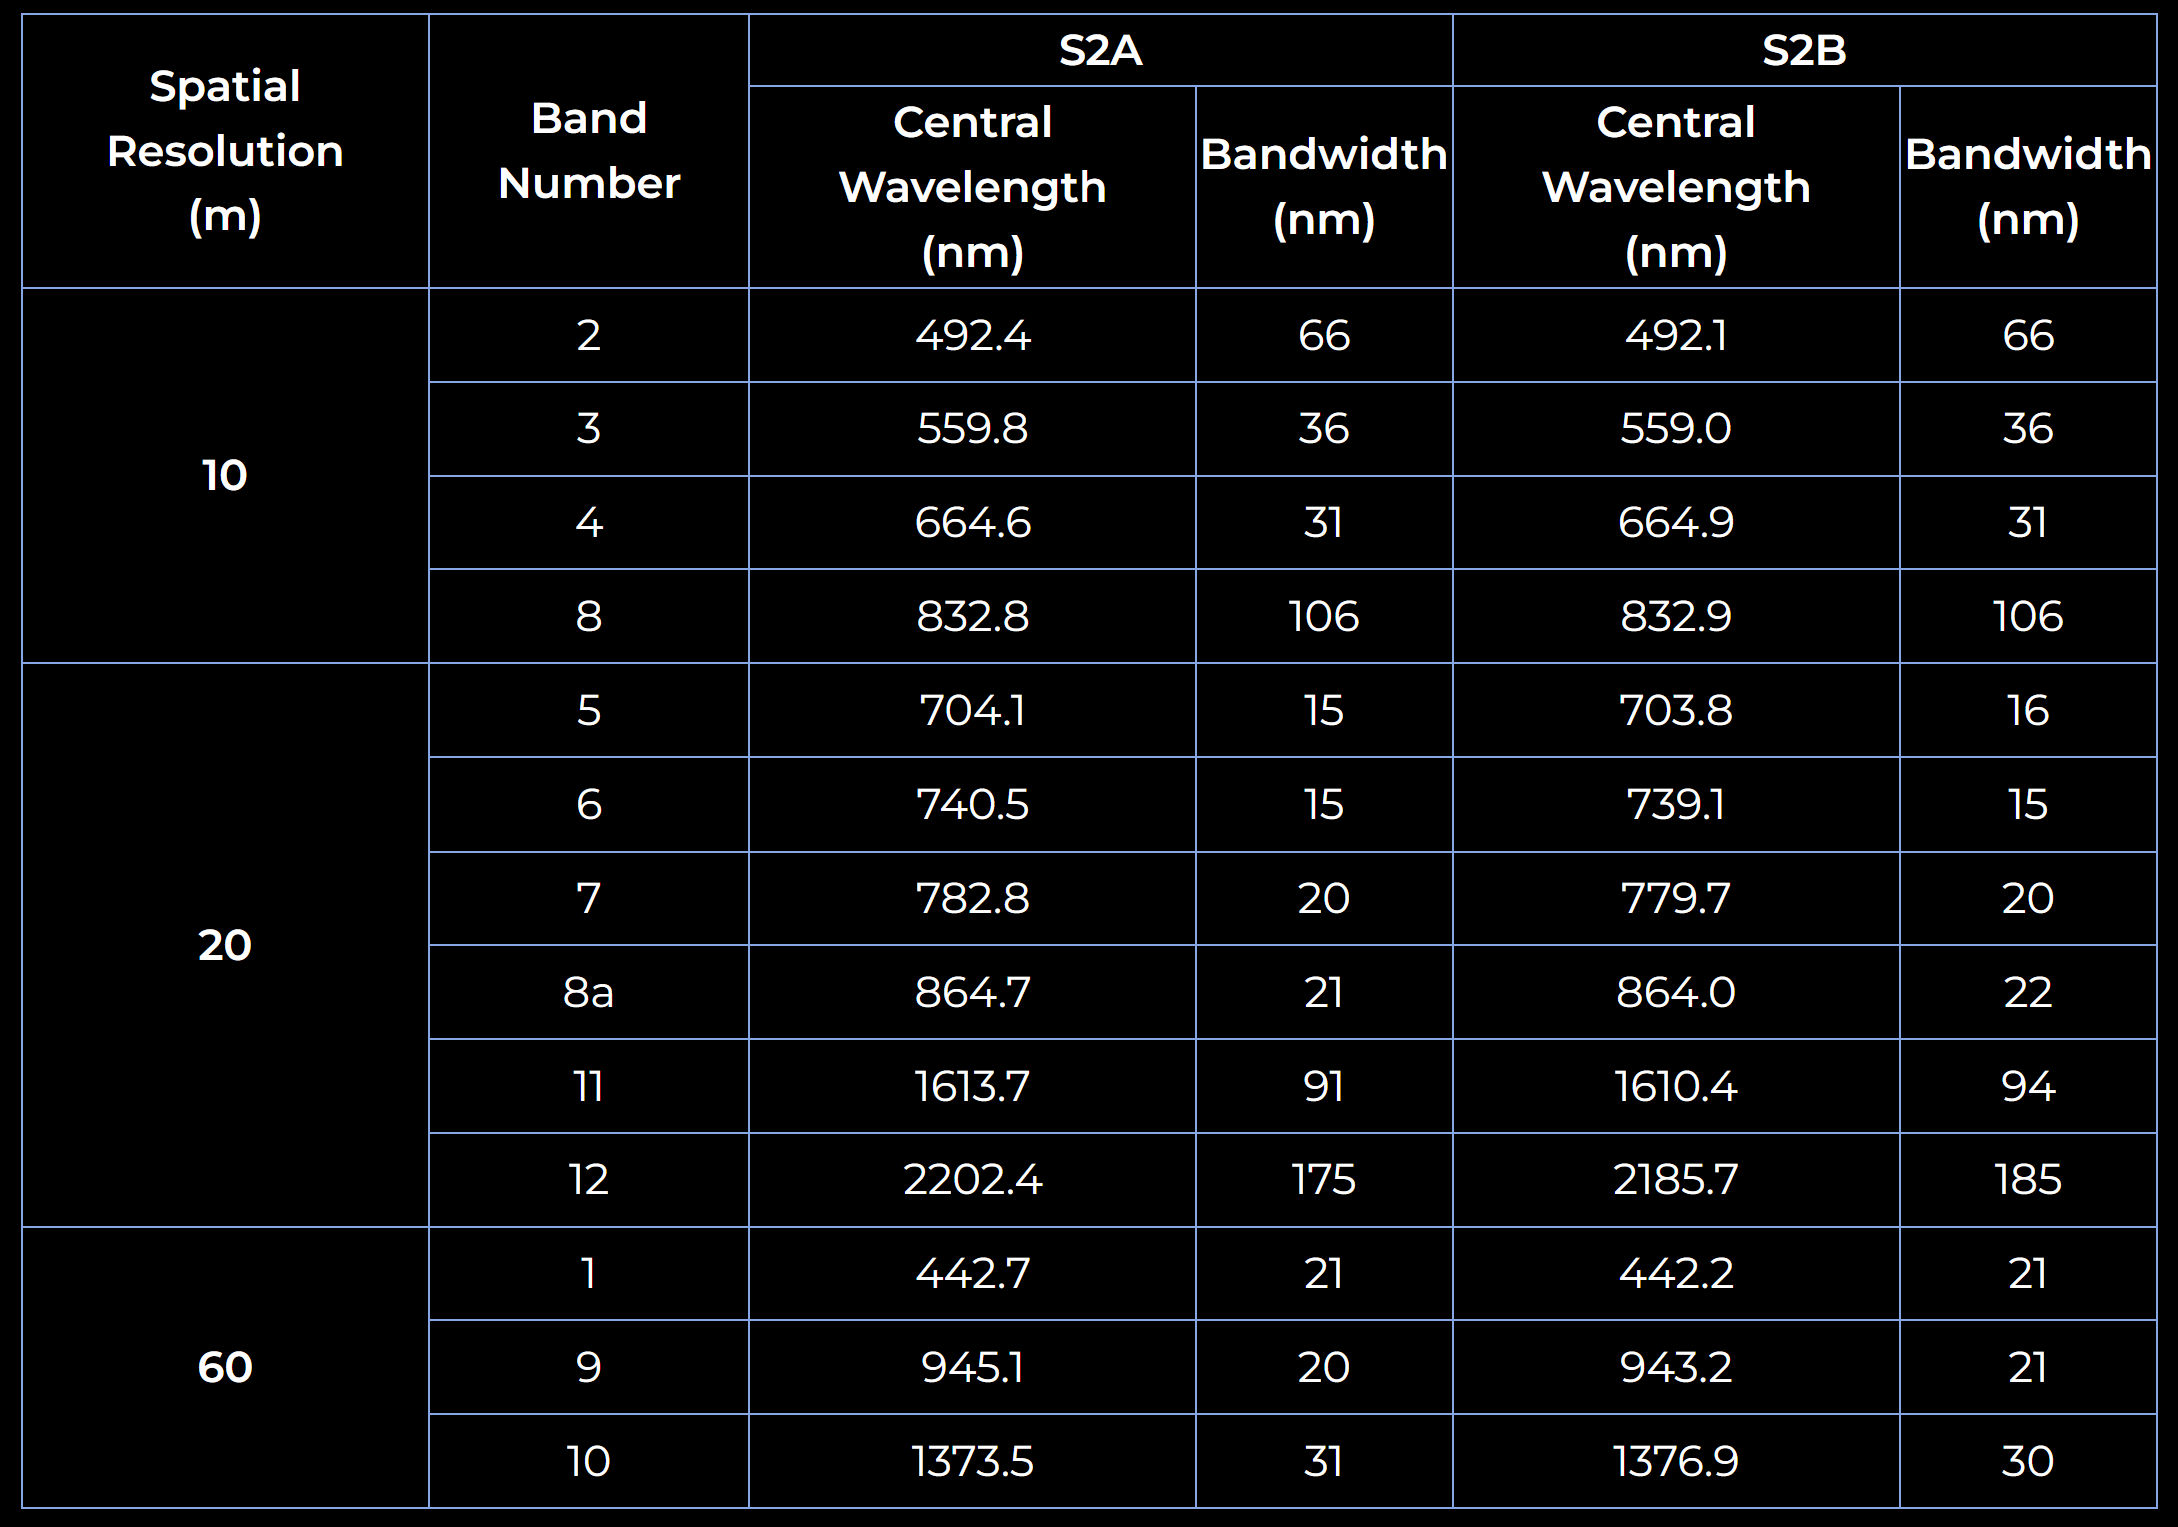

 The Sentinel-2 bands have a spatial resolution of between 10-60 meters, dependent on the band. Let's query the metadata to learn the spatial resolution of each band.

In [ ]:
# Spectral resolution of a single band
B2scale= Metadata.select('B2').projection().nominalScale()
print(B2scale.getInfo(), "meter spatial resolution")

10 meter spatial resolution


In [ ]:
# Spatial resolution of all bands

bandNames = Metadata.bandNames().getInfo()

for band in bandNames:
  resolution = Metadata.select(band).projection().nominalScale().getInfo()
  print(f'Resolution of {band} : {resolution}')

Resolution of B1 : 60
Resolution of B2 : 10
Resolution of B3 : 10
Resolution of B4 : 10
Resolution of B5 : 20
Resolution of B6 : 20
Resolution of B7 : 20
Resolution of B8 : 10
Resolution of B8A : 20
Resolution of B9 : 60
Resolution of B11 : 20
Resolution of B12 : 20
Resolution of AOT : 10
Resolution of WVP : 10
Resolution of SCL : 20
Resolution of TCI_R : 10
Resolution of TCI_G : 10
Resolution of TCI_B : 10
Resolution of MSK_CLDPRB : 20
Resolution of MSK_SNWPRB : 20
Resolution of QA10 : 10
Resolution of QA20 : 20
Resolution of QA60 : 60



# **GEE: False Composite**

A false composite is a type of image composite that combines different spectral bands in a non-standard way to highlight specific features or characteristics of the Earth's surface. Unlike a natural color composite, which combines red, green, and blue bands to resemble what the human eye sees, a false composite assigns bands to different color channels or uses bands not typically associated with red, green, and blue.

As mentioned early, a commonly used false composite is the "false-color infrared" composite, where the near-infrared band is assigned to the red channel, the red band to the green channel, and the green band to the blue channel. This composite enhances the visibility of healthy vegetation, as it highlights the strong reflectance of near-infrared light by healthy plants, making them appear bright red. Other false composites can be created to emphasize specific features such as water bodies, land cover changes, or geological formations.

False composites are valuable for a range of applications, including agriculture, forestry, and land-use analysis, as they reveal information that may not be apparent in natural color images and help in the interpretation of various Earth surface characteristics.

# False Image - RGB - 8,4,3

This combination of bands 8, 4, and 3 results in a false-color composite that enhances the visibility of healthy vegetation in red tones, while other land features, such as urban areas, water bodies, and barren land, appear in different hues, helping to distinguish various surface characteristics and changes over time. This type of composite is particularly useful for vegetation monitoring, land cover classification, and environmental assessments.

In [ ]:
Image =  ee.ImageCollection("COPERNICUS/S2_SR").filterDate(startDate, endDate).filter(ee.Filter.bounds(boundary)).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).sort('CLOUDY_PIXEL_PERCENTAGE').first()
FalseImage=Image.clip(boundary)

In [ ]:
# Display it on the Map

# Create a folium map object
my_map = folium.Map(location = [48.1351, 11.5820], zoom_start=12)


# Create False Image Vis
visParams_False = {
    'bands': ['B8', 'B4', 'B3'],
    'min': 0,
    'max': 4000
}


my_map.add_ee_layer(FalseImage,visParams_False, "False Image Vegetation")

# Add a layer control panel to the map
my_map.add_child(folium.LayerControl())

#Display the Map
display(my_map)


# False Image - RGB - 11,8,2

This composite, commonly referred to as the Agriculture RGB composite, combines the Short-Wave Infrared (SWIR-1 or B11), Near-Infrared (B08), and Blue (B02) bands. Its primary application is the monitoring of crop health, as both the short-wave and near-infrared bands excel in highlighting dense vegetation, which appears as a deep green in this composite. SWIR measurements aid in estimating the moisture content in plants and soil, given that water reflects SWIR light. Furthermore, shortwave-infrared bands are valuable for distinguishing between snow and ice, both of which appear white in visible light. They are also effective for mapping fire damage, as newly burned land reflects strongly in SWIR bands.

In [ ]:
# Display it on the Map

# Create a folium map object
my_map = folium.Map(location = [48.1351, 11.5820], zoom_start=12)


# Create False Image Vis
visParams_False_Agriculture = {
    'bands': ['B11', 'B8', 'B2'],
    'min': 0,
    'max': 4000
}


my_map.add_ee_layer(FalseImage,visParams_False_Agriculture, "False Image Agriculture")

# Add a layer control panel to the map
my_map.add_child(folium.LayerControl())

#Display the Map
display(my_map)


# **Self-Study Exercise**

Create a False Image with the bands of your choice in the location of your choice and in (at least) 200 words, explain why your choice in bands and explain what is being shown in the imagery

In [ ]:
# Load city boundaries and select Munich
ShapeIDD = ['COL-ADM2-3_0_0-B1101'] # Munich specific boundary
borders = ee.FeatureCollection('projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM2') # FeatureCollection of HPSCGS-ADM3 boundaries
boundary = borders.filter(ee.Filter.inList('shapeID', ShapeIDD)).geometry() # Filter the FeatureCollection for the Munich boundary

In [ ]:
#Select start and end date for imagery
startDate = "2024-01-01";
endDate = "2024-05-10";

In [ ]:
bands = ['B1', 'B2', 'B3', 'B4','B5', 'B6', 'B7', 'B8', 'B8A','B9',"B11", 'B12', "MSK_CLDPRB"]

In [ ]:
# Select Sentinel-2 Image COllection and filter Image Collection by date and select bands
S2A_ImageCollection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(startDate, endDate).filter(ee.Filter.bounds(boundary))
print("print all metadata:", S2A_ImageCollection.getInfo())

print all metadata: {'type': 'ImageCollection', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B6', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B7', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B8', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B8A', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {'id': 'B9', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}}, {

In [ ]:
print('Amount of available Images in the ImageCollection of BOGOTÁ in June 2023:', S2A_ImageCollection.size().getInfo())

Amount of available Images in the ImageCollection of BOGOTÁ in June 2023: 105


In [ ]:
#Mosaic the Image Collection to make it a singular Image
S2A_BaseImage_Mosaic = S2A_ImageCollection.mosaic()
print("print all metadata:",S2A_BaseImage_Mosaic.getInfo())

# Clip the base image by the Munich boundaries to ensure we only get an image that is the size of Munich
Bogota2020_Clipped = S2A_BaseImage_Mosaic.clip(boundary)

print all metadata: {'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B6', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'B7', 'data_type': {'type': 'PixelType'

In [ ]:
#Import the Folium Library
import folium

#Define a method for displaying EE image tiles to a folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles = map_id_dict['tile_fetcher'].url_format,
      attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name = name,
      overlay = True,
      control = True
  ).add_to(self)


# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
visParams = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 4000
}

# Create a folium map object
my_map = folium.Map(location = [4.5980, -74.0758], zoom_start=12)

#Display

my_map.add_ee_layer(Bogota2020_Clipped, visParams, "Bogotá 2020")

# Add a layer control panel to the map
my_map.add_child(folium.LayerControl())

#Display the Map
#display(my_map)

In [ ]:
#Check Image Collection for least cloudy image. **This code within this code box is NOT how you should filter images for clouds. This is just so you can understand how many images are severly obstructed by clouds. This is JUST filtering for scences that contain less than 30% clouds

collectionList = S2A_ImageCollection.toList(S2A_ImageCollection.size())
collectionSize = collectionList.size().getInfo()


In [ ]:
# Before using a mosaic to create the image, filter out cloudy images that have a cloud pixel percentage higher than 30. Typically, 10% to 20% is better
S2A_Image_Filtered_Clouds_30 = S2A_ImageCollection.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) # select the first() image to display an image
Munich2023_Clipped_Cloud_30 = S2A_Image_Filtered_Clouds_30.first().clip(boundary)

In [ ]:
# Display it on the Map
my_map.add_ee_layer(Munich2023_Clipped_Cloud_30, visParams, "Munich2023_Clipped_Cloud_30")
display(my_map)

In [ ]:
# Use this function to mask cloud pixels
def maskClouds(image):
    qa = image.select('MSK_CLDPRB')
    # Create a binary mask using the cloud probability band
    binary_mask = qa.lt(50)
    # Return the binary mask image
    return image.updateMask(binary_mask)

In [ ]:
S2A_Image_Filtered_Clouds_30_Masked= S2A_Image_Filtered_Clouds_30.map(maskClouds)

In [ ]:
# Display it on the Map
my_map = folium.Map(location = [4.5980, -74.0758], zoom_start=12)
my_map.add_ee_layer(S2A_Image_Filtered_Clouds_30_Masked.first().clip(boundary) , visParams, "Munich2023_Clipped_Cloud_30_Masked")
my_map.add_child(folium.LayerControl())
display(my_map)

In [ ]:
# Display it on the Map
my_map = folium.Map(location = [4.5980, -74.0758], zoom_start=12)
my_map.add_ee_layer(S2A_Image_Filtered_Clouds_30_Masked.median().clip(boundary) , visParams, "Munich2023_Clipped_Cloud_30_Masked")
my_map.add_child(folium.LayerControl())
display(my_map)

In [ ]:
Image =  ee.ImageCollection("COPERNICUS/S2_SR").filterDate(startDate, endDate).filter(ee.Filter.bounds(boundary)).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).sort('CLOUDY_PIXEL_PERCENTAGE').first()
FalseImage=Image.clip(boundary)

/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:202: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


# Description

In the cell below, we see the map of Bogotá, the capital of Colombia. What we see is the AOT filter applied to the map. This filter is intended to show the Aerosol Optical Thickness, which is the scattered and reflected sunlight, which is usually higher for more polluted areas. In this sense, the lighter areas are usually more polluted than the darker areas. This makes sense given that to the east of the map, we have the Eastern Hills, which are the mountains that surround the capital and are covered by vegetation, accounting for a less polluted environment. On the other hand, we have the lightest color to the west of the map. This also makes sense given that this is the industrial part of the city.
In the middle, we also have a lighter color which is the center of the city, where the majority of traffic activity takes place. Therefore, we can also see a considerably polluted area.

Bogotá has recently gone through a pollution crisis. In recent years, it became common to see a cloud of pollution over the city, especially in the early hours of the day. This pollution crisis is accounted for by car use to a large extent. It has become a requirement for the city to have a "no-car day" with the purpose of cleaning the air for at least a day. In this sense, I wanted to have a visual representation of how polluted the air is


In [ ]:
# Display it on the Map

# Create a folium map object
my_map = folium.Map(location = [4.5980, -74.0758], zoom_start=12)


# Create False Image Vis
visParams_False_Agriculture = {
    'bands': ['AOT'],
    'min': 90,
    'max': 100
}


my_map.add_ee_layer(FalseImage,visParams_False_Agriculture, "Water sources")

# Add a layer control panel to the map
my_map.add_child(folium.LayerControl())

#Display the Map
display(my_map)